to create audio recognition to small start word for non commercial voice assistant.
The word for recogintian is Marvin

In [1]:
#!pip install -U -q tensorflow tensorflow_datasets

Mount to google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load the libraries

In [64]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

import soundfile as sf
import librosa
import librosa.display
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

load precleaned dataset

In [36]:
DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/datasets/wake-word-examples/train/'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'wake-word-examples.zip',
      origin="/content/drive/MyDrive/Colab Notebooks/datasets/wake-word-examples.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

The dataset's audio clips are stored in 2 folders corresponding to speech command:

In [37]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['not-wake-word' 'wake-word']


Resample audio with union sample rate

In [38]:
def resample_audio(label):
  directory = '/content/drive/MyDrive/Colab Notebooks/datasets/wake-word-examples/train/'+label
  audio_files = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith('.wav')]
  for file_path in audio_files:
    audio_signal, current_sampling_rate = librosa.load(file_path, sr=None)  # sr=None returns the native sampling rate

    # Set the target sampling rate
    target_sampling_rate = 16000

    # Resample the audio signal
    resampled_audio = librosa.resample(audio_signal, orig_sr = current_sampling_rate, target_sr = target_sampling_rate)

    path = 'resample/'+label+"/"
    # Check whether the specified path exists or not
    isExist = os.path.exists(path)
    if not isExist:
      os.makedirs(path)
    output_file_path = '/content/resample/'+label+"/"+file_path.split('/')[-1]  # Replace this with the desired file path

    # Save the audio signal to a WAV file
    sf.write(output_file_path, data=resampled_audio, samplerate = target_sampling_rate)
  return "done!"

In [39]:
label = 'not-wake-word'
resample_audio(label)
label = 'wake-word'
resample_audio(label)

KeyboardInterrupt: ignored

Divided into directories this way, you can easily load the data using `keras.utils.audio_dataset_from_directory`.

The audio clips are 2 second or less at 16kHz. The `output_sequence_length=32000` pads the short ones to exactly 2 second (and would trim longer ones) so that they can be easily batched.

In [40]:
DATASET_PATH = '/content/resample'
data_dir = pathlib.Path(DATASET_PATH)

train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    shuffle=True,
    output_sequence_length=32000,
    subset='both',
    )

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 7751 files belonging to 2 classes.
Using 6201 files for training.
Using 1550 files for validation.

label names: ['not-wake-word' 'wake-word']


Create massive of the labesto find the weights

In [41]:
labels_array = np.concatenate([y.numpy() for _, y in train_ds], axis=0)

The dataset now contains batches of audio clips and integer labels. The audio clips have a shape of `(batch, samples, channels)`.

In [42]:
val_ds.element_spec

(TensorSpec(shape=(None, 32000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [43]:
train_ds.element_spec

(TensorSpec(shape=(None, 32000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

This dataset only contains single channel audio, so use the `tf.squeeze` function to drop the extra axis:

In [44]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

brake data on test and val split

In [45]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

### **EDA**



find the example

In [46]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 32000)
(64,)


Let's plot a few audio waveforms:

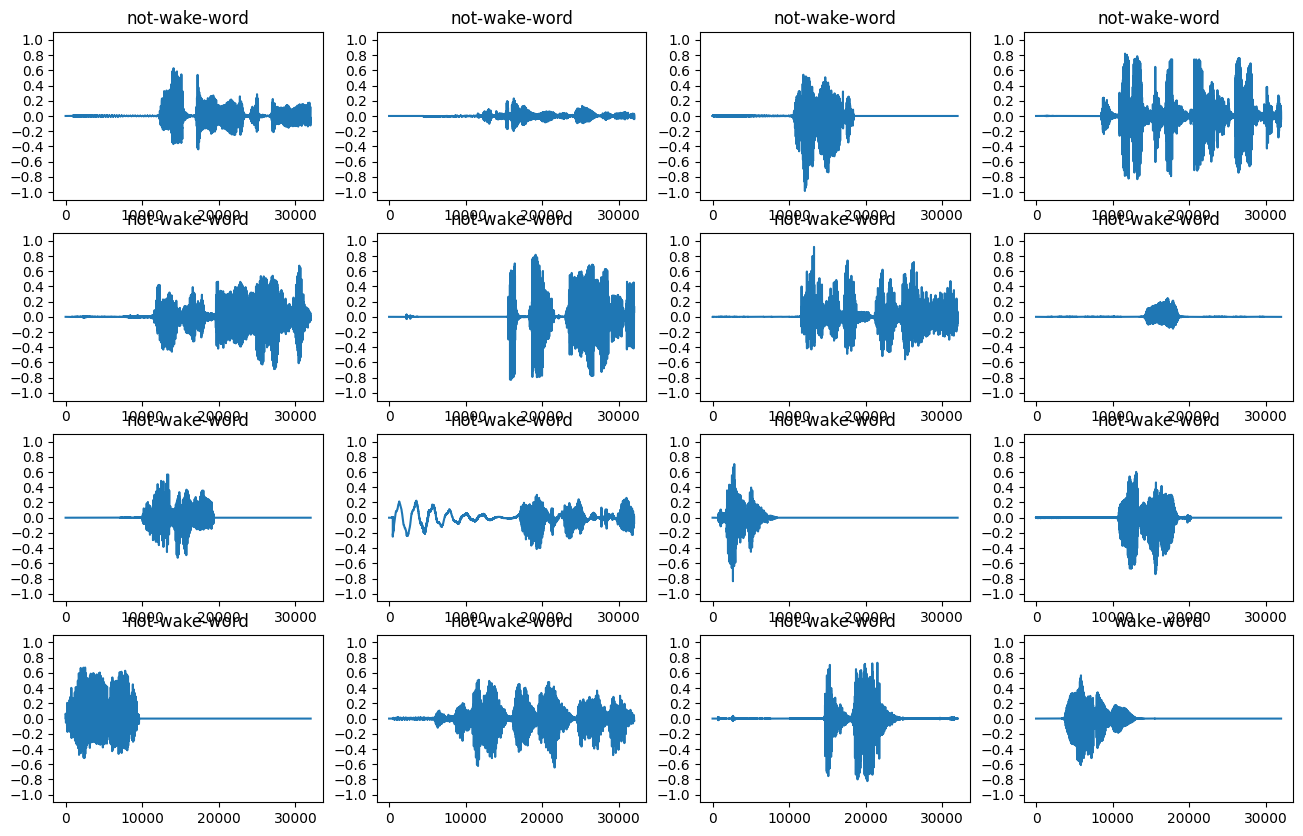

In [47]:
plt.figure(figsize=(16, 10))
rows = 4
cols = 4
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

In [48]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

Print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio:

In [49]:
for i in range(10):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: not-wake-word
Waveform shape: (32000,)
Spectrogram shape: (249, 129, 1)
Audio playback


Label: not-wake-word
Waveform shape: (32000,)
Spectrogram shape: (249, 129, 1)
Audio playback


Label: not-wake-word
Waveform shape: (32000,)
Spectrogram shape: (249, 129, 1)
Audio playback


Label: not-wake-word
Waveform shape: (32000,)
Spectrogram shape: (249, 129, 1)
Audio playback


Label: not-wake-word
Waveform shape: (32000,)
Spectrogram shape: (249, 129, 1)
Audio playback


Label: not-wake-word
Waveform shape: (32000,)
Spectrogram shape: (249, 129, 1)
Audio playback


Label: not-wake-word
Waveform shape: (32000,)
Spectrogram shape: (249, 129, 1)
Audio playback


Label: not-wake-word
Waveform shape: (32000,)
Spectrogram shape: (249, 129, 1)
Audio playback


Label: not-wake-word
Waveform shape: (32000,)
Spectrogram shape: (249, 129, 1)
Audio playback


Label: not-wake-word
Waveform shape: (32000,)
Spectrogram shape: (249, 129, 1)
Audio playback


Now, define a function for displaying a spectrogram:

In [50]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

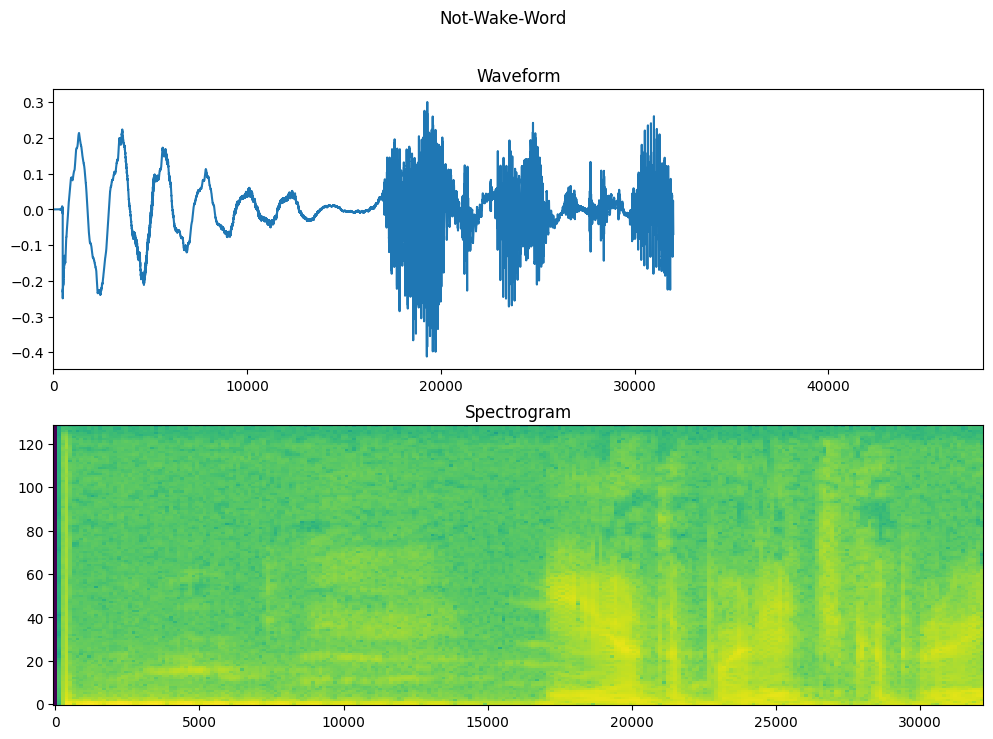

In [51]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 48000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Now, create spectrogram datasets from the audio datasets:

In [52]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [53]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Examine the spectrograms for different examples of the dataset:

In [54]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

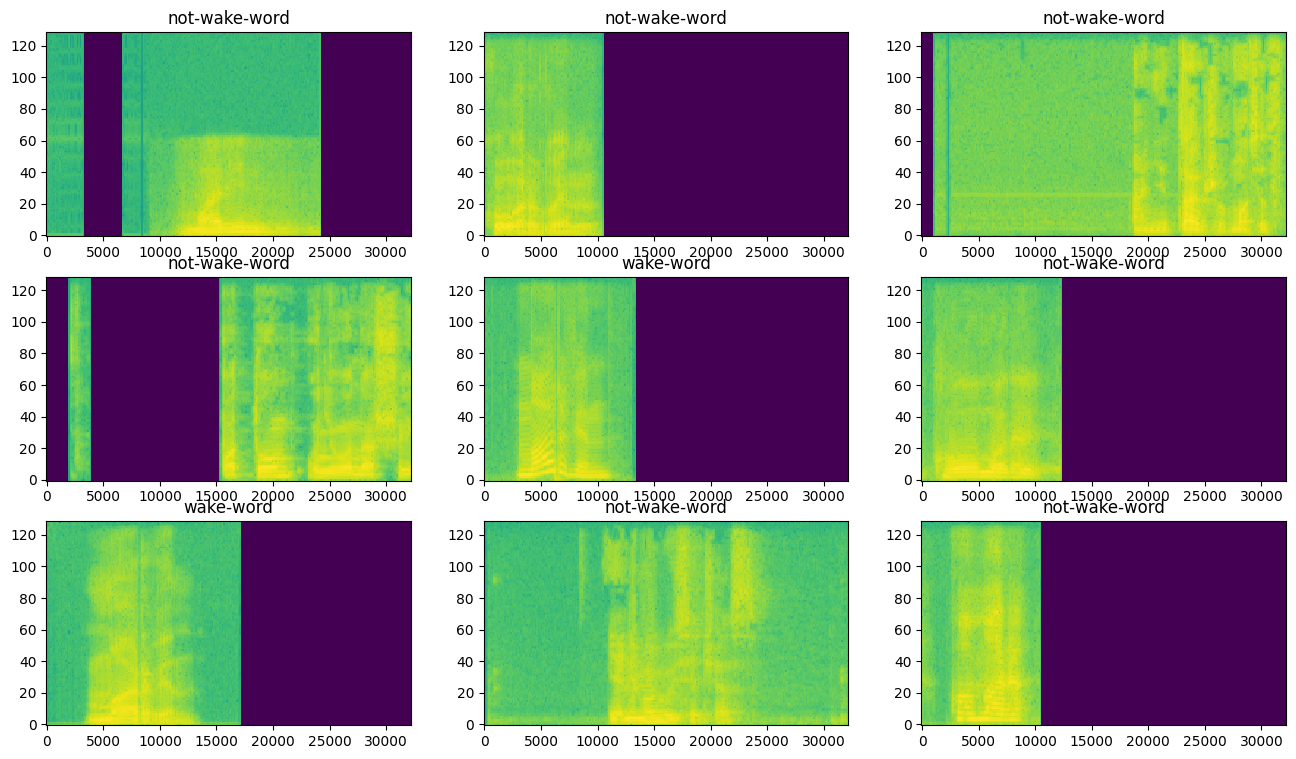

In [55]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

## Build and train the model

Add `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [56]:
train_spectrogram_ds = train_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [57]:


# Assuming you have your features (X_train) and labels (y_train) ready

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(labels_array), y=labels_array)

# Convert class weights to a dictionary
class_weight_dict = dict(enumerate(class_weights))

For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into spectrogram images.

Your `tf.keras.Sequential` model will use the following Keras preprocessing layers:

- `tf.keras.layers.Resizing`: to downsample the input to enable the model to train faster.
- `tf.keras.layers.Normalization`: to normalize each pixel in the image based on its mean and standard deviation.

For the `Normalization` layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (that is, the mean and the standard deviation).

In [58]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

Input shape: (249, 129, 1)


Define model

In [65]:
def make_model(learning_rate = 0.01, dropout_rate = 0.1):
      model = models.Sequential([
          layers.Input(shape=input_shape),
          # Downsample the input.
          layers.Resizing(32, 32),
          # Normalize.
          norm_layer,
          layers.Conv2D(32, 3, activation='relu'),
          layers.Conv2D(64, 3, activation='relu'),
          layers.MaxPooling2D(),
          layers.Dropout(dropout_rate),
          layers.Flatten(),
          layers.Dense(128, activation='relu'),
          layers.Dropout(dropout_rate),
          layers.Dense(num_labels)
      ])
      model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate = learning_rate),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'], sample_weight_mode=class_weight_dict,
        )

      return model

Cheakpoints

In [66]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'Sequential_v1_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only = True,
    monitor = 'val_accuracy',
    mode = 'max'
)

See what gives the best results

In [70]:
scores = {}

for learning_rate in [0.001,0.01, 0.1, 1]:
    print(learning_rate)
    model = make_model(learning_rate = learning_rate)
    EPOCHS = 5
    history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)
    scores[learning_rate]=history.history
    print()
    print()



0.001
Epoch 1/5
97/97 [==============================] - 12s 68ms/step - loss: 0.2020 - accuracy: 0.9144 - val_loss: 0.1603 - val_accuracy: 0.9440
Epoch 2/5
97/97 [==============================] - 1s 10ms/step - loss: 0.1446 - accuracy: 0.9389 - val_loss: 0.1113 - val_accuracy: 0.9609
Epoch 3/5
97/97 [==============================] - 1s 9ms/step - loss: 0.1056 - accuracy: 0.9540 - val_loss: 0.0767 - val_accuracy: 0.9714
Epoch 4/5
97/97 [==============================] - 1s 9ms/step - loss: 0.0697 - accuracy: 0.9708 - val_loss: 0.0466 - val_accuracy: 0.9753
Epoch 5/5
97/97 [==============================] - 1s 9ms/step - loss: 0.0439 - accuracy: 0.9806 - val_loss: 0.0250 - val_accuracy: 0.9961


0.01
Epoch 1/5
97/97 [==============================] - 2s 10ms/step - loss: 0.2533 - accuracy: 0.8994 - val_loss: 0.1680 - val_accuracy: 0.9180
Epoch 2/5
97/97 [==============================] - 1s 9ms/step - loss: 0.1684 - accuracy: 0.9313 - val_loss: 0.1171 - val_accuracy: 0.9557
Epoch 3/5


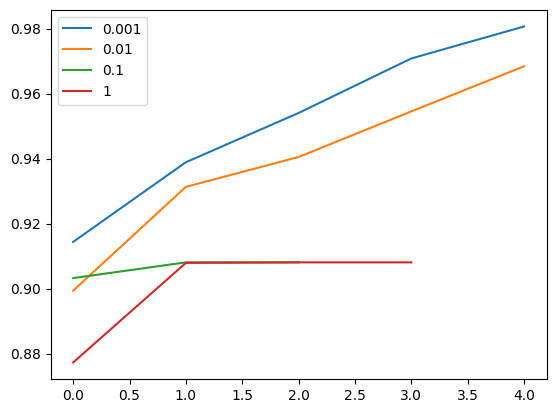

In [71]:
for lr, hist in scores.items():
    plt.plot(hist['accuracy'], label = lr)
    #plt.xtick(np.arange(10))
    plt.legend()



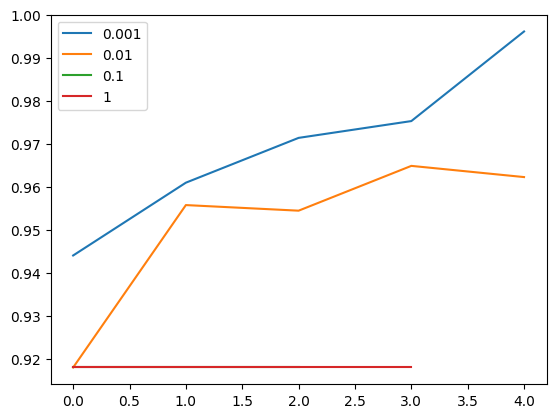

In [72]:
for lr, hist in scores.items():
    plt.plot(hist['val_accuracy'], label = lr)
    #plt.xtick(np.arange(10))
    plt.legend()

In [73]:
scores = {}

for dropout_rate in [0.1,0.4, 0.8]:
    print(dropout_rate)
    model = make_model(dropout_rate = dropout_rate)
    EPOCHS = 5
    history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)
    scores[dropout_rate]=history.history
    print()
    print()

In [74]:
for lr, hist in scores.items():
    plt.plot(hist['accuracy'], label = lr)
    #plt.xtick(np.arange(10))
    plt.legend()

In [75]:
for lr, hist in scores.items():
    plt.plot(hist['val_accuracy'], label = lr)
    #plt.xtick(np.arange(10))
    plt.legend()

Ceate final model

In [76]:
model = make_model()
EPOCHS = 15
history = model.fit(
train_spectrogram_ds,validation_data=val_spectrogram_ds,
epochs=EPOCHS,
callbacks =[checkpoint],)

Epoch 1/15
97/97 [==============================] - 5s 20ms/step - loss: 0.2836 - accuracy: 0.9060 - val_loss: 0.1764 - val_accuracy: 0.9271
Epoch 2/15
12/97 [==>...........................] - ETA: 0s - loss: 0.1760 - accuracy: 0.9362

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


97/97 [==============================] - 1s 13ms/step - loss: 0.1524 - accuracy: 0.9379 - val_loss: 0.1127 - val_accuracy: 0.9505
Epoch 3/15
97/97 [==============================] - 1s 13ms/step - loss: 0.1149 - accuracy: 0.9529 - val_loss: 0.0900 - val_accuracy: 0.9570
Epoch 4/15
97/97 [==============================] - 1s 13ms/step - loss: 0.1011 - accuracy: 0.9536 - val_loss: 0.0725 - val_accuracy: 0.9727
Epoch 5/15
97/97 [==============================] - 1s 15ms/step - loss: 0.0807 - accuracy: 0.9640 - val_loss: 0.0653 - val_accuracy: 0.9779
Epoch 6/15
97/97 [==============================] - 1s 13ms/step - loss: 0.0634 - accuracy: 0.9719 - val_loss: 0.0628 - val_accuracy: 0.9896
Epoch 7/15
97/97 [==============================] - 1s 11ms/step - loss: 0.0889 - accuracy: 0.9642 - val_loss: 0.1173 - val_accuracy: 0.9701
Epoch 8/15
97/97 [==============================] - 1s 11ms/step - loss: 0.0708 - accuracy: 0.9740 - val_loss: 0.0538 - val_accuracy: 0.9792
Epoch 9/15
97/97 [======

Train the model over 15 epochs for demonstration purposes:

Let's plot the training and validation loss curves to check how your model has improved during training:

Text(0, 0.5, 'Accuracy [%]')

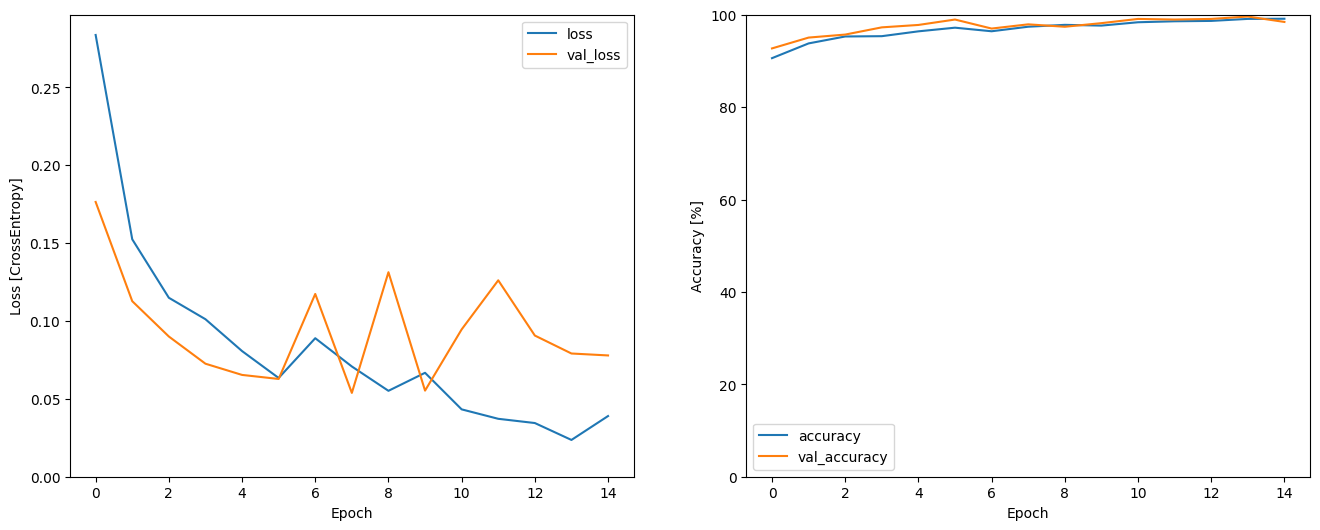

In [77]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

## Evaluate the model performance

Run the model on the test set and check the model's performance:

In [78]:
model.evaluate(test_spectrogram_ds, return_dict=True)

13/13 [==============================] - 2s 153ms/step - loss: 0.0955 - accuracy: 0.9859


{'loss': 0.09548046439886093, 'accuracy': 0.9859334826469421}

### Display a confusion matrix

Use a confusion matrix to check how well the model did classifying each of the commands in the test set:


In [79]:
y_pred = model.predict(test_spectrogram_ds)

13/13 [==============================] - 0s 4ms/step


In [80]:
y_pred = tf.argmax(y_pred, axis=1)

In [81]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

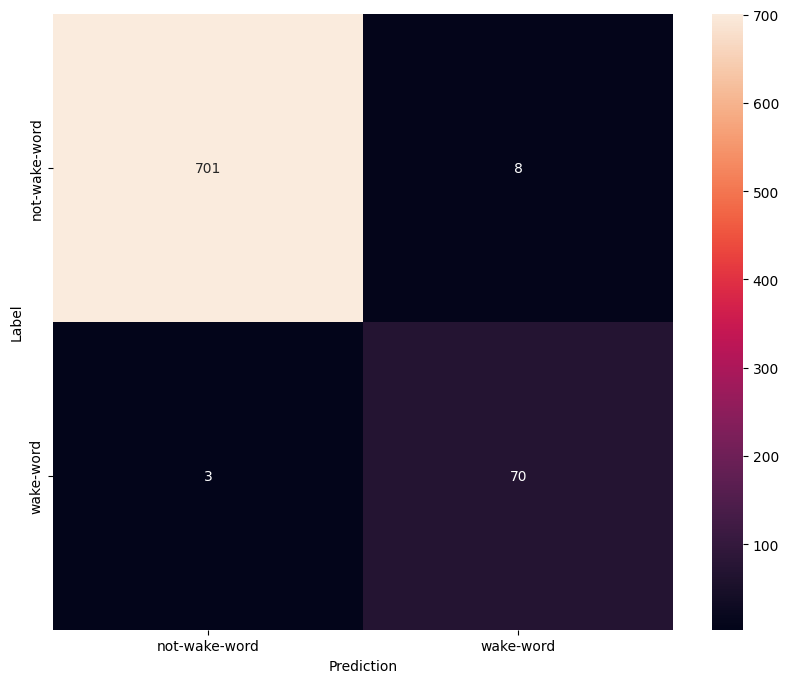

In [82]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Run inference on an audio file

Finally, verify the model's prediction output using an input audio file of someone saying "no". How well does your model perform?

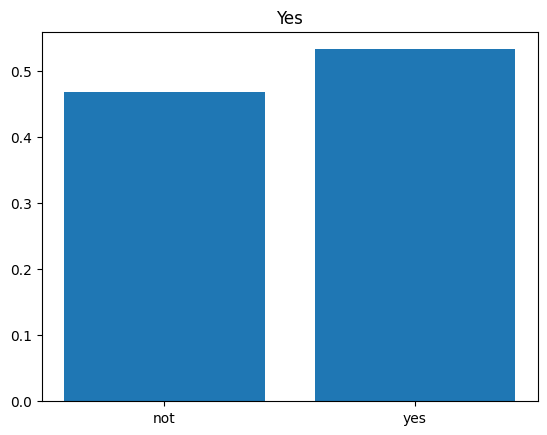

In [83]:
x = data_dir/'wake-word/silero_m_arvin_v4_cyrillic_b_cv_24000.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=32000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = ['not', 'yes']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('Yes')
plt.show()

display.display(display.Audio(waveform, rate=16000))

Result in numbers

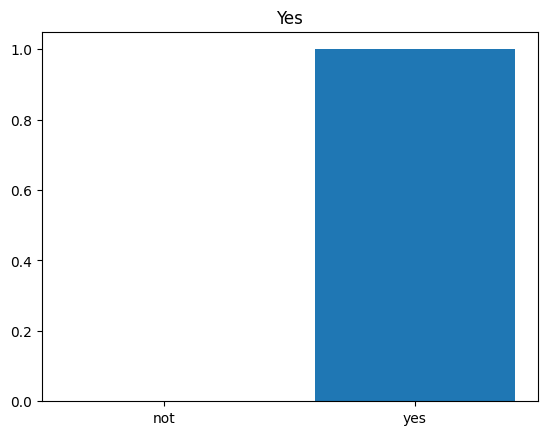

In [84]:
x = data_dir/'wake-word/silero_m_arvin_v4_cyrillic_b_mhr_48000.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=32000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = ['not', 'yes']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('Yes')
plt.show()

display.display(display.Audio(waveform, rate=16000))

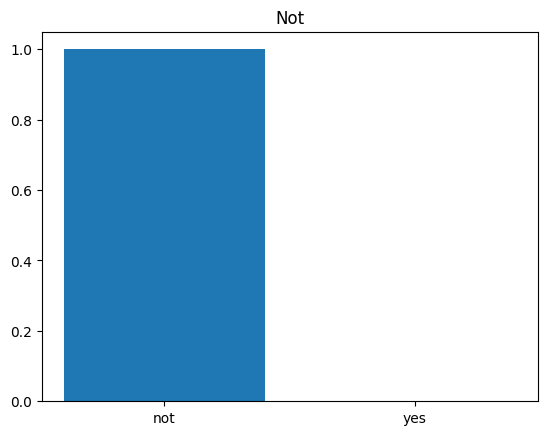

In [85]:
x = '/content/resample/not-wake-word/common_voice_ru_18852113.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=32000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = ['not', 'yes']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('Not')
plt.show()

display.display(display.Audio(waveform, rate=16000))

As the output suggests, your model should have recognized the audio command as "no".

## Export the model with preprocessing

In [86]:
model.save('model_v1.h5', save_format = 'h5')

Test run the "export" model:

Save and reload the model, the reloaded model gives identical output:

In [87]:
model = keras.models.load_model('/content/model_v1.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('marvin_voice.tflite', 'wb') as f_out:
    f_out.write(tflite_model)

### Load the model and predict

In [88]:
import tensorflow.lite as tflite
from tensorflow.io import read_file
from tensorflow.audio import decode_wav
from tensorflow import squeeze
from tensorflow import newaxis
from tensorflow.signal import stft
from tensorflow import abs
import pathlib

In [89]:
x = data_dir/'wake-word/silero_m_arvin_v4_cyrillic_b_cv_24000.wav'
x = read_file(str(x))
x, sample_rate = decode_wav(x, desired_channels=1, desired_samples=32000,)
x = squeeze(x, axis=-1)
waveform = x
spectrogram = stft(x, frame_length=255, frame_step=128)
spectrogram = abs(spectrogram)
x = spectrogram[..., newaxis]
X = x[newaxis,...]

display.display(display.Audio(waveform, rate=32000))

In [92]:
interpreter = tflite.Interpreter(model_path='/content/marvin_voice.tflite')
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']

interpreter.set_tensor(input_index, X)
interpreter.invoke()

preds = interpreter.get_tensor(output_index)

tf.nn.softmax(preds)

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.46751422, 0.53248584]], dtype=float32)>